In [1]:
# Import required libraries

from keras.layers import Add, Input
from keras.layers import Convolution2D, Convolution2DTranspose
import matplotlib.pyplot as plt
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import numpy as np
import glob
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Dataset/DIP

/content/drive/MyDrive/Dataset/DIP


In [4]:
# Defining PSNR value

def PSNR(y_pred, y_true):
    return 48.1308036087 - (10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.))

In [5]:
# Loading training images path

x = glob.glob('DRIVE/training/images/*')

In [6]:
x[4].split('/')[-1].split('.')[0].split('_')[0]

'21'

In [23]:
# Creating training dataset with image size 320x320

x_train = np.zeros((len(x), 320, 320, 3))
y_train = np.zeros((len(x), 320, 320, 3))
count = 0
for i in x:
  img1 = cv2.imread(i)
  img1_name = i.split('/')[-1].split('.')[0].split('_')[0]
  cap = cv2.VideoCapture('DRIVE/training/1st_manual/' + img1_name + '_manual1.gif')
  ret, img2 = cap.read()
  img1 = cv2.resize(img1, (320, 320))
  img2 = cv2.resize(img2, (320, 320))
  x_train[count] = img1
  y_train[count] = img2
  count += 1

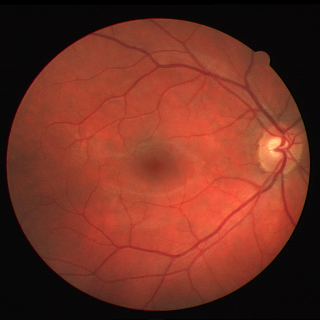

In [24]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_train[0])

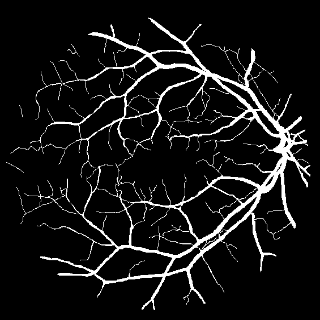

In [25]:
cv2_imshow(y_train[0])

In [53]:
def acc(y_pred, y_true, smooth=1):
  count = 0
  y_pred = y_pred.numpy()
  y_true = y_true.numpy()
  y_pred = y_pred.reshape((320*320*3, 1))
  y_true = y_true.reshape((320*320*3, 1))
  for i in range(len(y_pred)):
    if y_pred[i] == y_true[i]:
      count += 1
  return count/len(y_pred)

In [54]:
# Defining the architecture of REDNet-20

init = Input(shape = (320, 320, 3))
level1_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(init)
level2_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level1_1)
level3_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level2_1)
level4_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level3_1)
level5_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level4_1)
level6_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level5_1)
level7_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level6_1)
level8_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level7_1)
level9_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level8_1)
level10_1 = Convolution2D(64, (3, 3), padding = 'same', activation = 'relu')(level9_1)

level10_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level10_1)
level10 = Add()([level10_1, level10_2])

level9_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level10)
level9 = Add()([level9_1, level9_2])

level8_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level9)
level8 = Add()([level8_1, level8_2])

level7_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level8)
level7 = Add()([level7_1, level7_2])

level6_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level7)
level6 = Add()([level6_1, level6_2])

level5_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level6)
level5 = Add()([level5_1, level5_2])

level4_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level5)
level4 = Add()([level4_1, level4_2])

level3_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level4)
level3 = Add()([level3_1, level3_2])

level2_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level3)
level2 = Add()([level2_1, level2_2])

level1_2 = Convolution2DTranspose(64, (3, 3), padding = 'same', activation = 'relu')(level2)
level1 = Add()([level1_1, level1_2])

decoded = Convolution2D(3, (3, 3), activation = 'linear', padding = 'same')(level1)

# Initiating the model REDNet-4
rednet20 = Model(init, decoded)
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
rednet20.compile(optimizer=adam, loss='mse', metrics = [PSNR, acc], run_eagerly=True)

In [ ]:
rednet20.summary()

In [ ]:
# Training the model
hist = rednet20.fit(x_train, y_train, epochs = 50, batch_size = 1, verbose = 1)

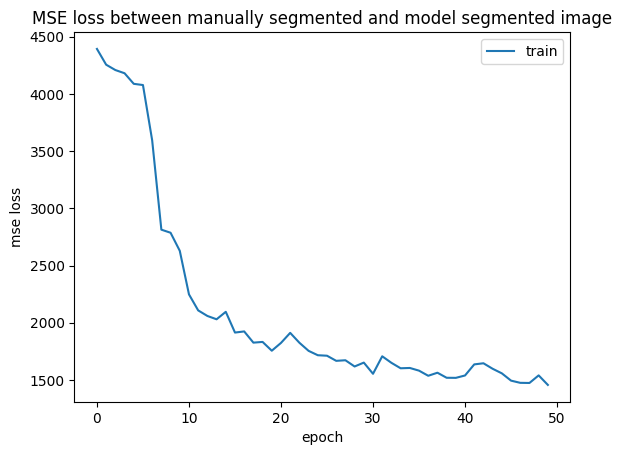

In [59]:
plt.plot(hist.history['loss'])
plt.title('MSE loss between manually segmented and model segmented image')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [60]:
t1 = x_train[0].reshape(1, 320, 320, 3)
t = rednet20.predict(t1)

1/1 [==============================] - 0s 49ms/step


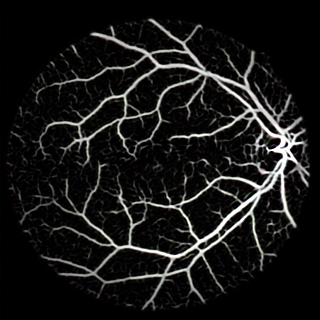

In [61]:
t = t.reshape(320, 320, 3)
cv2_imshow(t)

### **Testing**

In [62]:
x_test = glob.glob('DRIVE/test/images/*')

In [63]:
test = cv2.imread(x_test[3])

In [64]:
img1 = cv2.resize(test, (320, 320), interpolation = cv2.INTER_NEAREST)

In [65]:
img1 = img1.reshape(1, 320, 320, 3)

In [66]:
img = rednet20.predict(img1)

1/1 [==============================] - 0s 64ms/step


In [67]:
img = img.reshape(320, 320, 3)

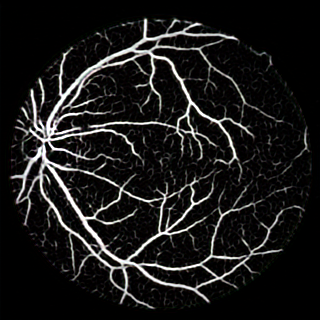

In [68]:
cv2_imshow(img)

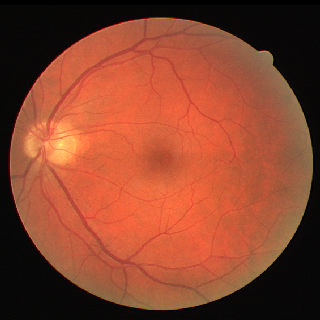

In [69]:
test = cv2.resize(test, (320, 320), interpolation = cv2.INTER_NEAREST)
cv2_imshow(test)